# `Spatial Analysis of Mapped 3D Timeseries Data`

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    To answer the question : is my region of interest homogeneous?
</div>

### Importing the python libraries you'll need: basic setup

In [1]:
# Data Wrangling
import netCDF4 as nc
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, date2num, num2date
from matplotlib import gridspec
from shapely.geometry import LinearRing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Statistics
import pymannkendall as mk
from scipy.stats import linregress
from scipy.stats import kruskal
import scikit_posthocs as sp

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Set data path and filename

In [2]:
path = "data/"
file = "METOFFICE-GLO-SST-L4-REP-OBS-SST_WestnCape.nc"

### Open netCDF and inspect variables

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; text-align: center; border-radius: 8px;">

        Look inside your netcdf file to determine your variable name, e.g.: `thetao` or `analysed_sst`
<div>

In [3]:
nc_ = nc.Dataset(os.path.join(path, file))
nc_

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.11
    title: Global SST & Sea Ice Analysis, L4 OSTIA, 0.05 deg daily (METOFFICE-GLO-SST-L4-REP-OBS-SST-V2)
    institution: UKMO
    source: AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, GOES<13,16>-OSISAF-L3C-v2.0, SEVIRI-OSISAF-L3C-v2.0, SLSTRA-C3S-L3C-v2.0, ATSR<1,2>-ESACCI-L3U-v2.0, AATSR-ESACCI-L3U-v2.0, AVHRR<07,09,11,12,14,15,16,17,18,19,MTA>-ESACCI-L3U-v2.0, GMI-REMSS-L3U-v2.0, VIIRS<NPP,N20>-OSPO-L3U-v2.0, OSISAF_ICE
    history: Created from sst.nc; obs_anal.nc; seaice.nc
    references: Donlon, C.J., Martin, M., Stark, J.D., Roberts-Jones, J., Fiedler, E., Wimmer, W., 2011. The Operational Sea Surface Temperature and Sea Ice Analysis (OSTIA). Remote Sensing of the Environment
    comment: WARNING Some applications are unable to properly handle signed byte values. If values are encountered > 127, please subtract 256 from this reported value
    subset:source: ARCO data d

In [4]:
# Print dimensions of yr target variable
nc_.variables['analysed_sst'].dimensions

('time', 'latitude', 'longitude')

### Extract SST, coordinates, and time

In [5]:
# Target variable
var = nc_.variables['analysed_sst'][:] - 273.15       # Optional: if in Kelvin convert to degrees Celcius
# Dimensions
time= nc_.variables['time']
lat = nc_.variables['latitude'][:]
lon = nc_.variables['longitude'][:]

# Sanity check
print('(Number of timesteps, size lat, size lon) -->', var.shape)

(Number of timesteps, size lat, size lon) --> (14610, 100, 120)


### Visual quick‐look using `imshow`

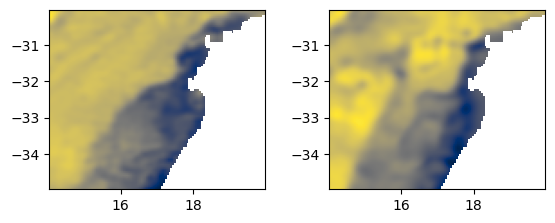

In [6]:
# Create figure, axis object
# subplot(r,c) no. rows,cols
fig, ax = plt.subplots(1, 2)   
# add a gap between subplots
fig.subplots_adjust(wspace = 0.30)     

# pick random numbers from zero to length of timeseries (minus 1)
ax[0].imshow(var[111],  extent = 
                [lon.min(), lon.max(), lat.min(), lat.max()], cmap = 'cividis')
ax[1].imshow(var[300], extent = 
                [lon.min(), lon.max(), lat.min(), lat.max()], cmap = 'cividis');

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    0. Trend analysis for a single pixel (space) over full dataseries (time)
</div>

In [7]:
# Select a pixel from AoI
LAT_p, LON_p = -32.5, 18
lat_ind = np.argmin(np.abs(lat - LAT_p))
lon_ind = np.argmin(np.abs(lon - LON_p))

# List values at pixel (_p) over timeseries
var_p = []
var_p = [var[t, lat_ind, lon_ind] for t in range(var.shape[0])]

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; text-align: center; border-radius: 8px;">

    Linear Regression: Ordinary Least Squares (OLS)
<div>

### Convert time‐units to datetimes

In [8]:
caldr = time.getncattr('calendar')
units = time.getncattr('units')
dtime = nc.num2date(time[:], units, calendar  = caldr,
                    only_use_cftime_datetimes = False)

In [9]:
# numeric x in days
x = mdates.date2num(dtime)
slope0, intercept0, r_val0, p_val0, std_err0 = linregress(x, var_p)

# total change over time series (in days)
days  = x[-1] - x[0]
total0 = slope0 * days

print(f"Slope : {slope0:.6f} °C /day")
print(f"Change: {total0:.6f} °C over time ({days:.0f} days)")
print(f"p-val = {p_val0:.3g}")

# prepare fit line for plotting (next cell)
x_fit0 = np.linspace(x.min(), x.max(), 100)
y_fit0 = intercept0 + slope0 * x_fit0

Slope : -0.000043 °C /day
Change: -0.633428 °C over time (14609 days)
p-val = 9.7e-67


In [10]:
# Count unique years
years = len(set([dt.year for dt in dtime]))
print("Number of years in time series:", years)

Number of years in time series: 40


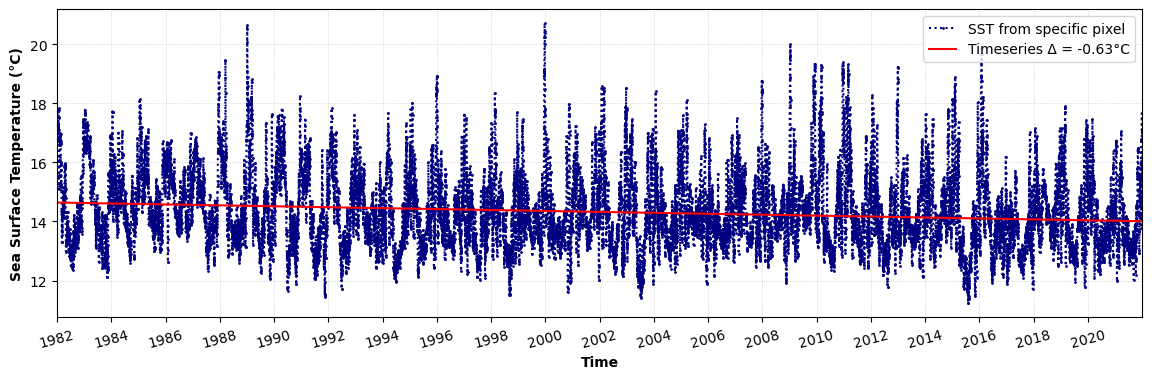

In [11]:
# Create a figure and axis object
fig1, ax = plt.subplots(figsize = (14, 4))

# plot values from pixel over time
ax.plot(dtime, var_p, linestyle = ':', linewidth = 1.5, marker = 'o', markersize = 1, 
        color = 'navy', label = 'SST from specific pixel')
# plot regression line
ax.plot(num2date(x_fit0), y_fit0, 'r-', linewidth = 1.5,
       label = f"Timeseries Δ = {total0:.2f}°C")

# Set axis labels and title
ax.set_xlabel('Time', fontsize = 10, weight = 'bold')
ax.set_ylabel('Sea Surface Temperature (°C)', fontsize = 10, weight = 'bold')

# Add grid formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
# Set x-axis limits with Date min to max
ax.set_xlim([np.nanmin(x), np.nanmax(x)])

# Date Formatting: Define x-axis locator (n yrs)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
# Format x-axis as Year (%Y)/ Year-Month (%Y-%m)
date_form = DateFormatter('%Y')                
# Rotate x-axis labels n degrees
plt.setp(ax.get_xticklabels(), rotation = 15)  

# Display
ax.legend()
plt.show()

<div class = "alert alert-info" role = "alert">
    
    Statistical Testing for Trends: Mann-Kendall
<div>

In [12]:
# Perform Mann Kendall Test
trend_true = mk.original_test(var_p)

# Print results in a friendly format
print("Daily SST")
print("• Trend:", trend_true[0])
print("• P-val:", ("%.4f" % trend_true[2]))

Daily SST
• Trend: decreasing
• P-val: 0.0000


In [13]:
# simple series of variable over time (timeseries, ts_)
ts0 = pd.Series(var_p, index = dtime)

# Positions min/max values
max0 = np.nanargmax(var_p)
min0 = np.nanargmin(var_p)

print("Mean:", round(ts0.mean(),   2))
print("Med :", round(ts0.median(), 2))
print("Min :", round(ts0.min(), 2), "on", ts0.idxmin(), "at position", min0)
print("Max :", round(ts0.max(), 1), "on", ts0.idxmax(), "at position", max0)

Mean: 14.33
Med : 14.11
Min : 11.24 on 2015-08-03 00:00:00 at position 12267
Max : 20.7 on 1999-12-23 00:00:00 at position 6565


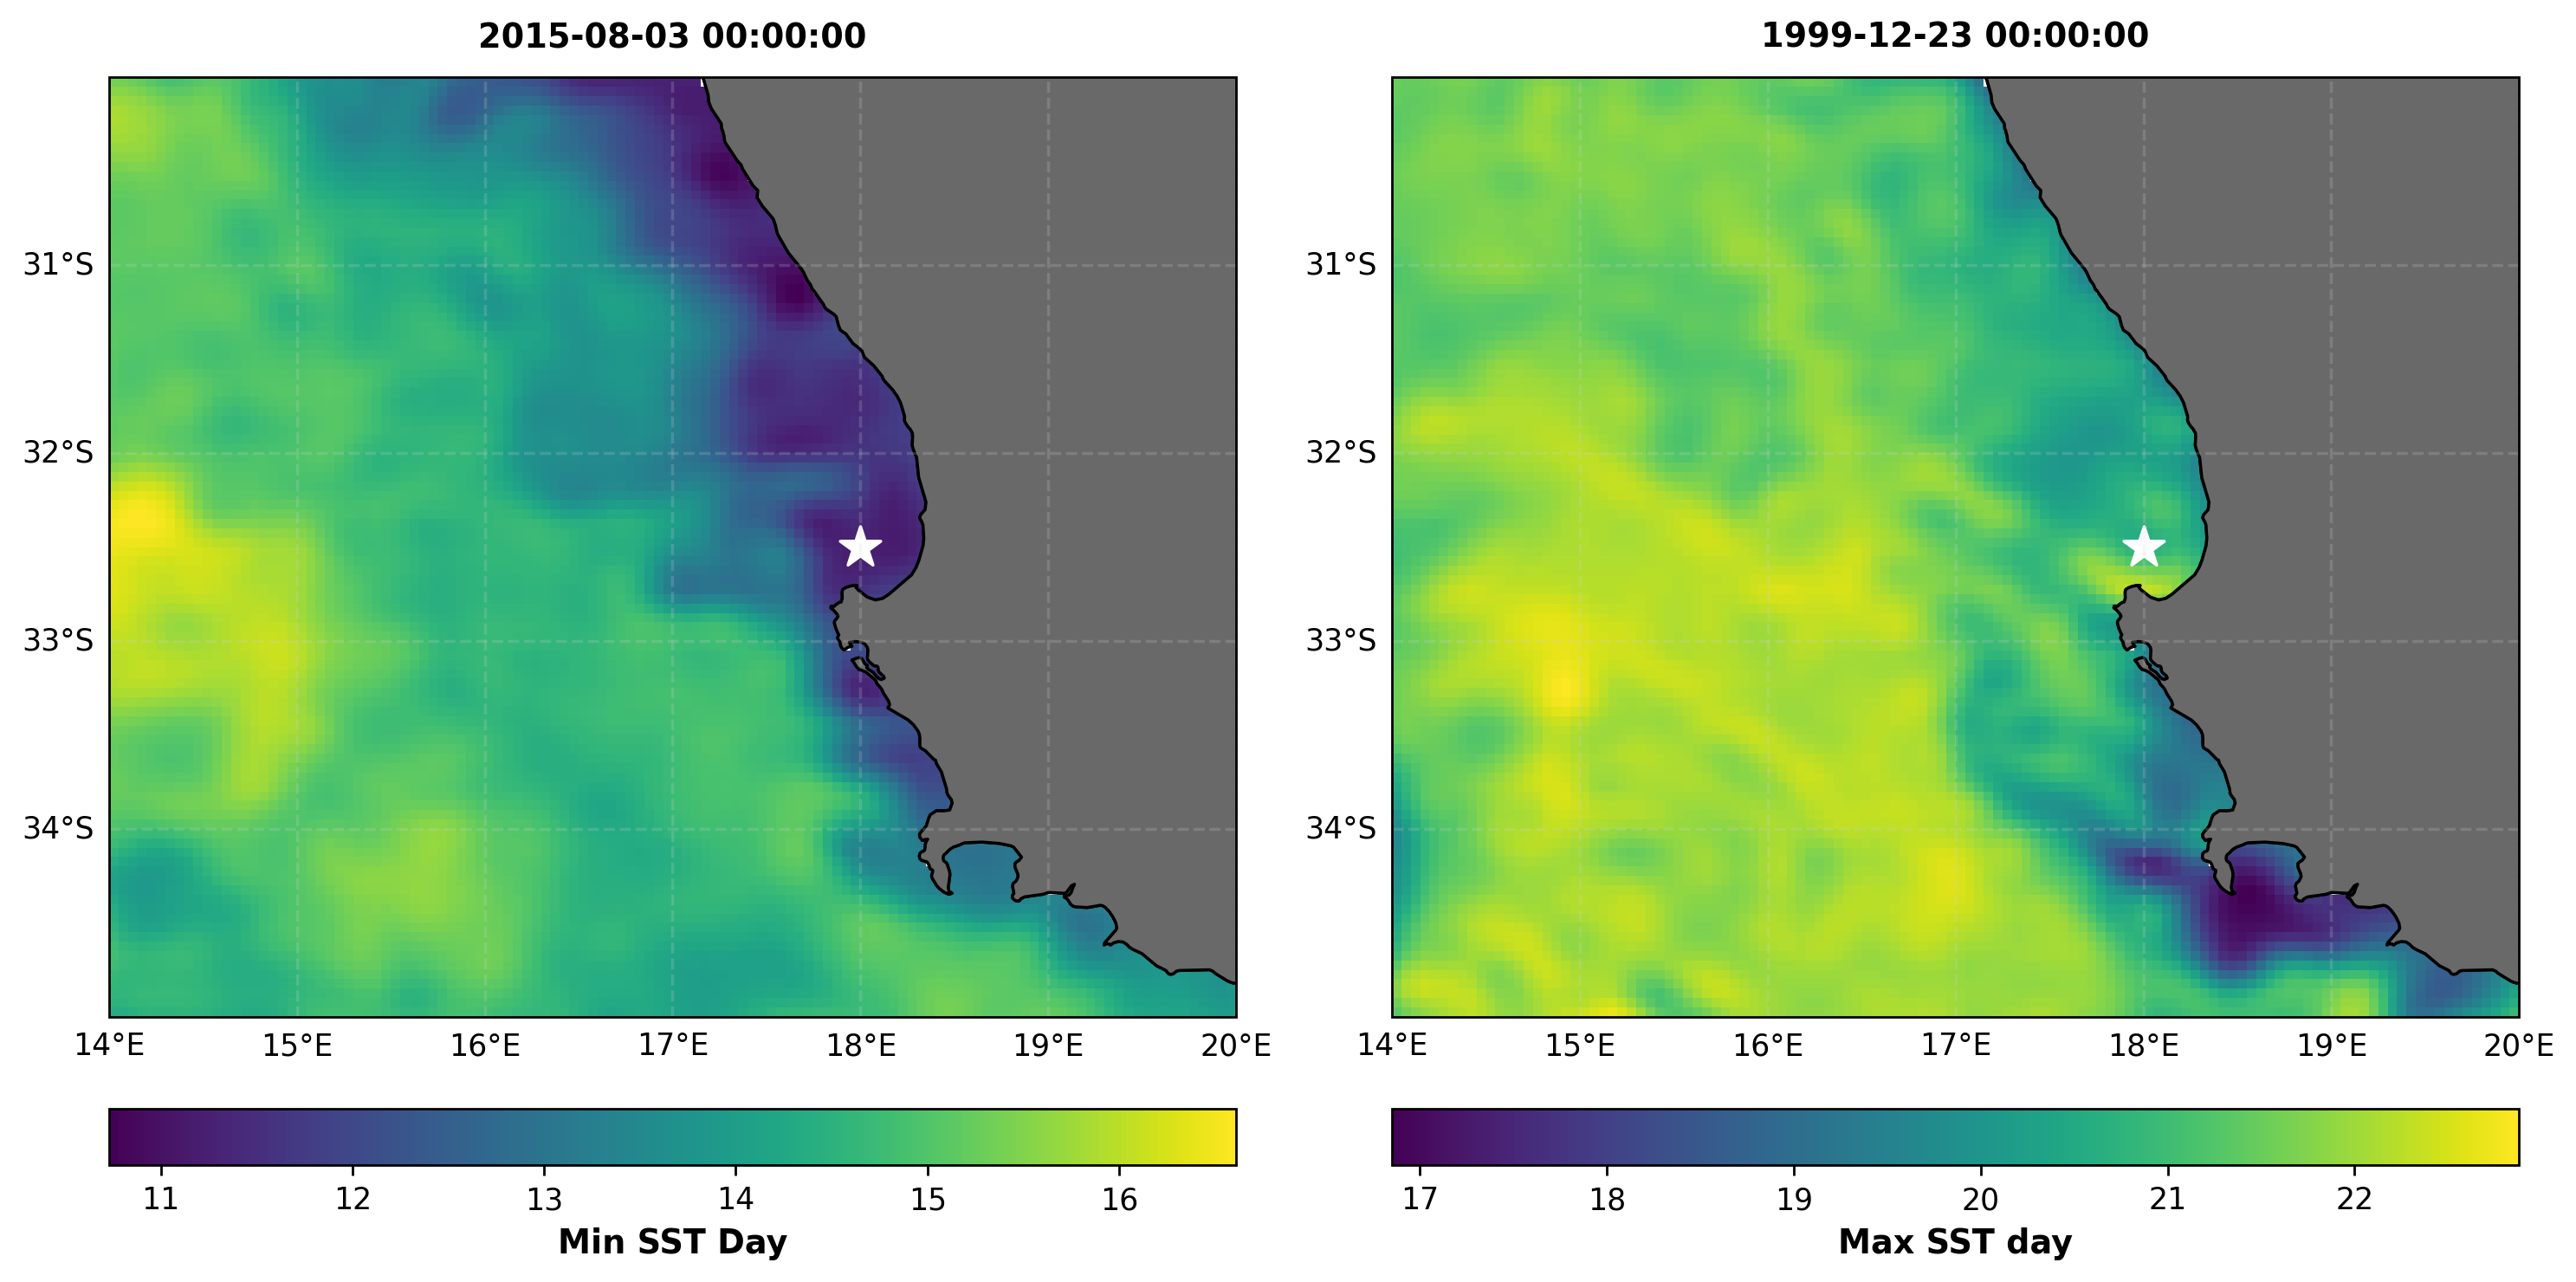

In [14]:
# shared settings for both sub-plots
proj = ccrs.PlateCarree(central_longitude = 0.0)
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor = 'k', facecolor = 'dimgrey')
# shared *kwargs (keyword arguments)
grids_kwargs = dict(draw_labels = True, linewidth = 1, alpha = 0.2,
                    linestyle = '--', color = 'lightgray')
point_kwargs = dict(transform = ccrs.PlateCarree(), marker = '*',
                    color = 'white', s = 200)
cbars_kwargs = dict(orientation = 'horizontal', fraction = 0.054, pad = 0.08)
# ---------------------------------------------------------------------------
# Plot min and max SST days
fig2 = plt.figure(figsize = (12, 6), dpi = 250)   # Create figure, axis object   
gs = gridspec.GridSpec(1, 2, figure = fig2)

# Subplot 1: minimum var val
ax = fig2.add_subplot(gs[0, 0], projection = proj)
im = ax.pcolormesh(lon, lat, var[min0], cmap = 'viridis')
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False
# add selected pixel position
ax.scatter(LON_p, LAT_p, **point_kwargs)
# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Min SST Day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts0.idxmin(), fontsize = 11, weight = 'bold', pad = 10)

# Subplot 2: maximum var val
ax = fig2.add_subplot(gs[0, 1], projection = proj)
im = ax.pcolormesh(lon, lat, var[max0], cmap = 'viridis')
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False
# add selected pixel position
ax.scatter(LON_p, LAT_p, **point_kwargs)
# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Max SST day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts0.idxmax(), fontsize = 11, weight = 'bold', pad = 10)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    1. Trend analysis for a subset (space) over full dataseries (time)
</div>

In [15]:
LAT_s = [-34, -33]
LON_s = [15, 16]

# index positions corresponding to min and max lats and lons in the subset
lat_min_idx = np.argmin(np.abs(lat - LAT_s[0]))
lat_max_idx = np.argmin(np.abs(lat - LAT_s[1]))
lon_min_idx = np.argmin(np.abs(lon - LON_s[0]))
lon_max_idx = np.argmin(np.abs(lon - LON_s[1]))

In [16]:
# I always get these confused and in the wrong order, this is my cheat code so it doesn't break my code!
# If the lat indices are/ are not in the right order, correct if necessary
lat_lo, lat_hi = sorted([lat_min_idx, lat_max_idx])
lon_lo, lon_hi = sorted([lon_min_idx, lon_max_idx])

# slice objects (upper bound is exclusive → add +1)
lat_sl = slice(lat_lo, lat_hi + 1)
lon_sl = slice(lon_lo, lon_hi + 1)

In [17]:
# List values in subset (_s) over timeseries
var_s = []
var_s = np.nanmean(var[:, lat_sl, lon_sl], axis = (1, 2))

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; text-align: center; border-radius: 8px;">

    Linear Regression: Ordinary Least Squares (OLS)
<div>

In [18]:
slope1, intercept1, r_val1, p_val1, std_err1 = linregress(x, var_s)

# total change over time series (in days)
total1 = slope1 * days

print(f"Slope : {slope1:.6f} °C /day")
print(f"Change: {total1:.6f} °C over time ({days:.0f} days)")
print(f"p-val = {p_val1:.3g}")

# prepare fit line for plotting (next cell)
x_fit1 = np.linspace(x.min(), x.max(), 100)
y_fit1 = intercept1 + slope1 * x_fit1

Slope : 0.000030 °C /day
Change: 0.434111 °C over time (14609 days)
p-val = 1.04e-15


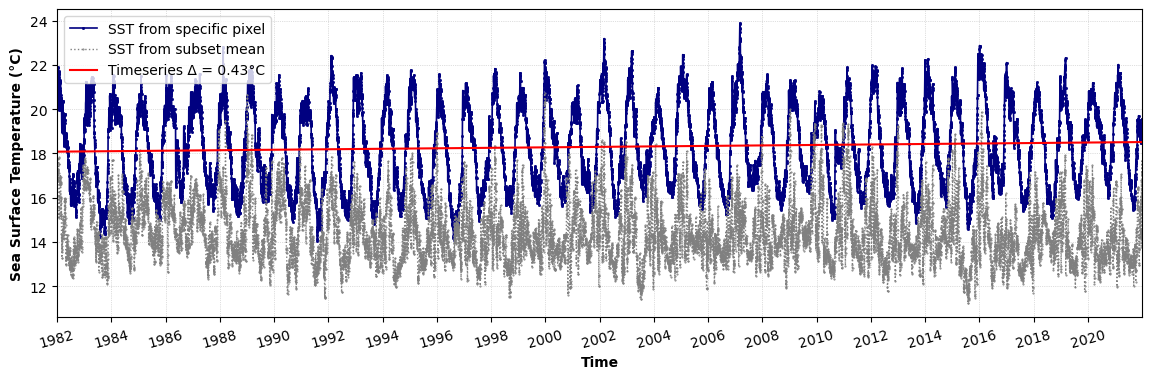

In [19]:
# Create a figure and axis object
fig3, ax = plt.subplots(figsize = (14, 4))

# plot values from pixel over time
ax.plot(dtime, var_s, linewidth = 1.2, linestyle = '-', marker = 's', markersize = 1, 
        color = 'navy',  label = 'SST from specific pixel')
# plot values from subset over time
ax.plot(dtime, var_p, linewidth = 1.0, linestyle = ':', marker = '.', markersize = 1, 
        color = 'grey', label = 'SST from subset mean')

# plot regression line/s
ax.plot(num2date(x_fit1), y_fit1, '-r', linewidth = 1.5,
       label = f"Timeseries Δ = {total1:.2f}°C")
#ax.plot(num2date(x_fit0), y_fit0, linestyle = '--', color = 'maroon', linewidth = 1.5)

# Set axis labels and title
ax.set_xlabel('Time', fontsize = 10, weight = 'bold')
ax.set_ylabel('Sea Surface Temperature (°C)', fontsize = 10, weight = 'bold')

# Add grid formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
# Set x-axis limits with Date min to max
ax.set_xlim([np.nanmin(x), np.nanmax(x)])

# Date Formatting: Define x-axis locator (n yrs)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
# Format x-axis as Year (%Y)/ Year-Month (%Y-%m)
date_form = DateFormatter('%Y')                
# Rotate x-axis labels n degrees
plt.setp(ax.get_xticklabels(), rotation = 15)  

# Display
ax.legend()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; text-align: center; border-radius: 8px;">
    
    Statistical Testing for Trends: Mann-Kendall
<div>

In [20]:
# Perform Mann Kendall Test
trend_true = mk.original_test(var_s)

# Print results in a friendly format
print("Daily SST")
print("• Trend:", trend_true[0])
print("• P-val:", ("%.4f" % trend_true[2]))

Daily SST
• Trend: increasing
• P-val: 0.0000


In [21]:
# simple series of variable over time (timeseries, ts1)
ts1 = pd.Series(var_s, index = dtime)

# Positions min/max values
max1 = np.nanargmax(var_s)
min1 = np.nanargmin(var_s)

print("Mean:", round(ts1.mean(),   2))
print("Med :", round(ts1.median(), 2))
print("Min :", round(ts1.min(), 2), "on", ts1.idxmin(), "at position", min1)
print("Max :", round(ts1.max(), 1), "on", ts1.idxmax(), "at position", max1)

Mean: 18.3
Med : 18.22
Min : 14.05 on 1991-08-09 00:00:00 at position 3507
Max : 23.9 on 2007-03-05 00:00:00 at position 9194


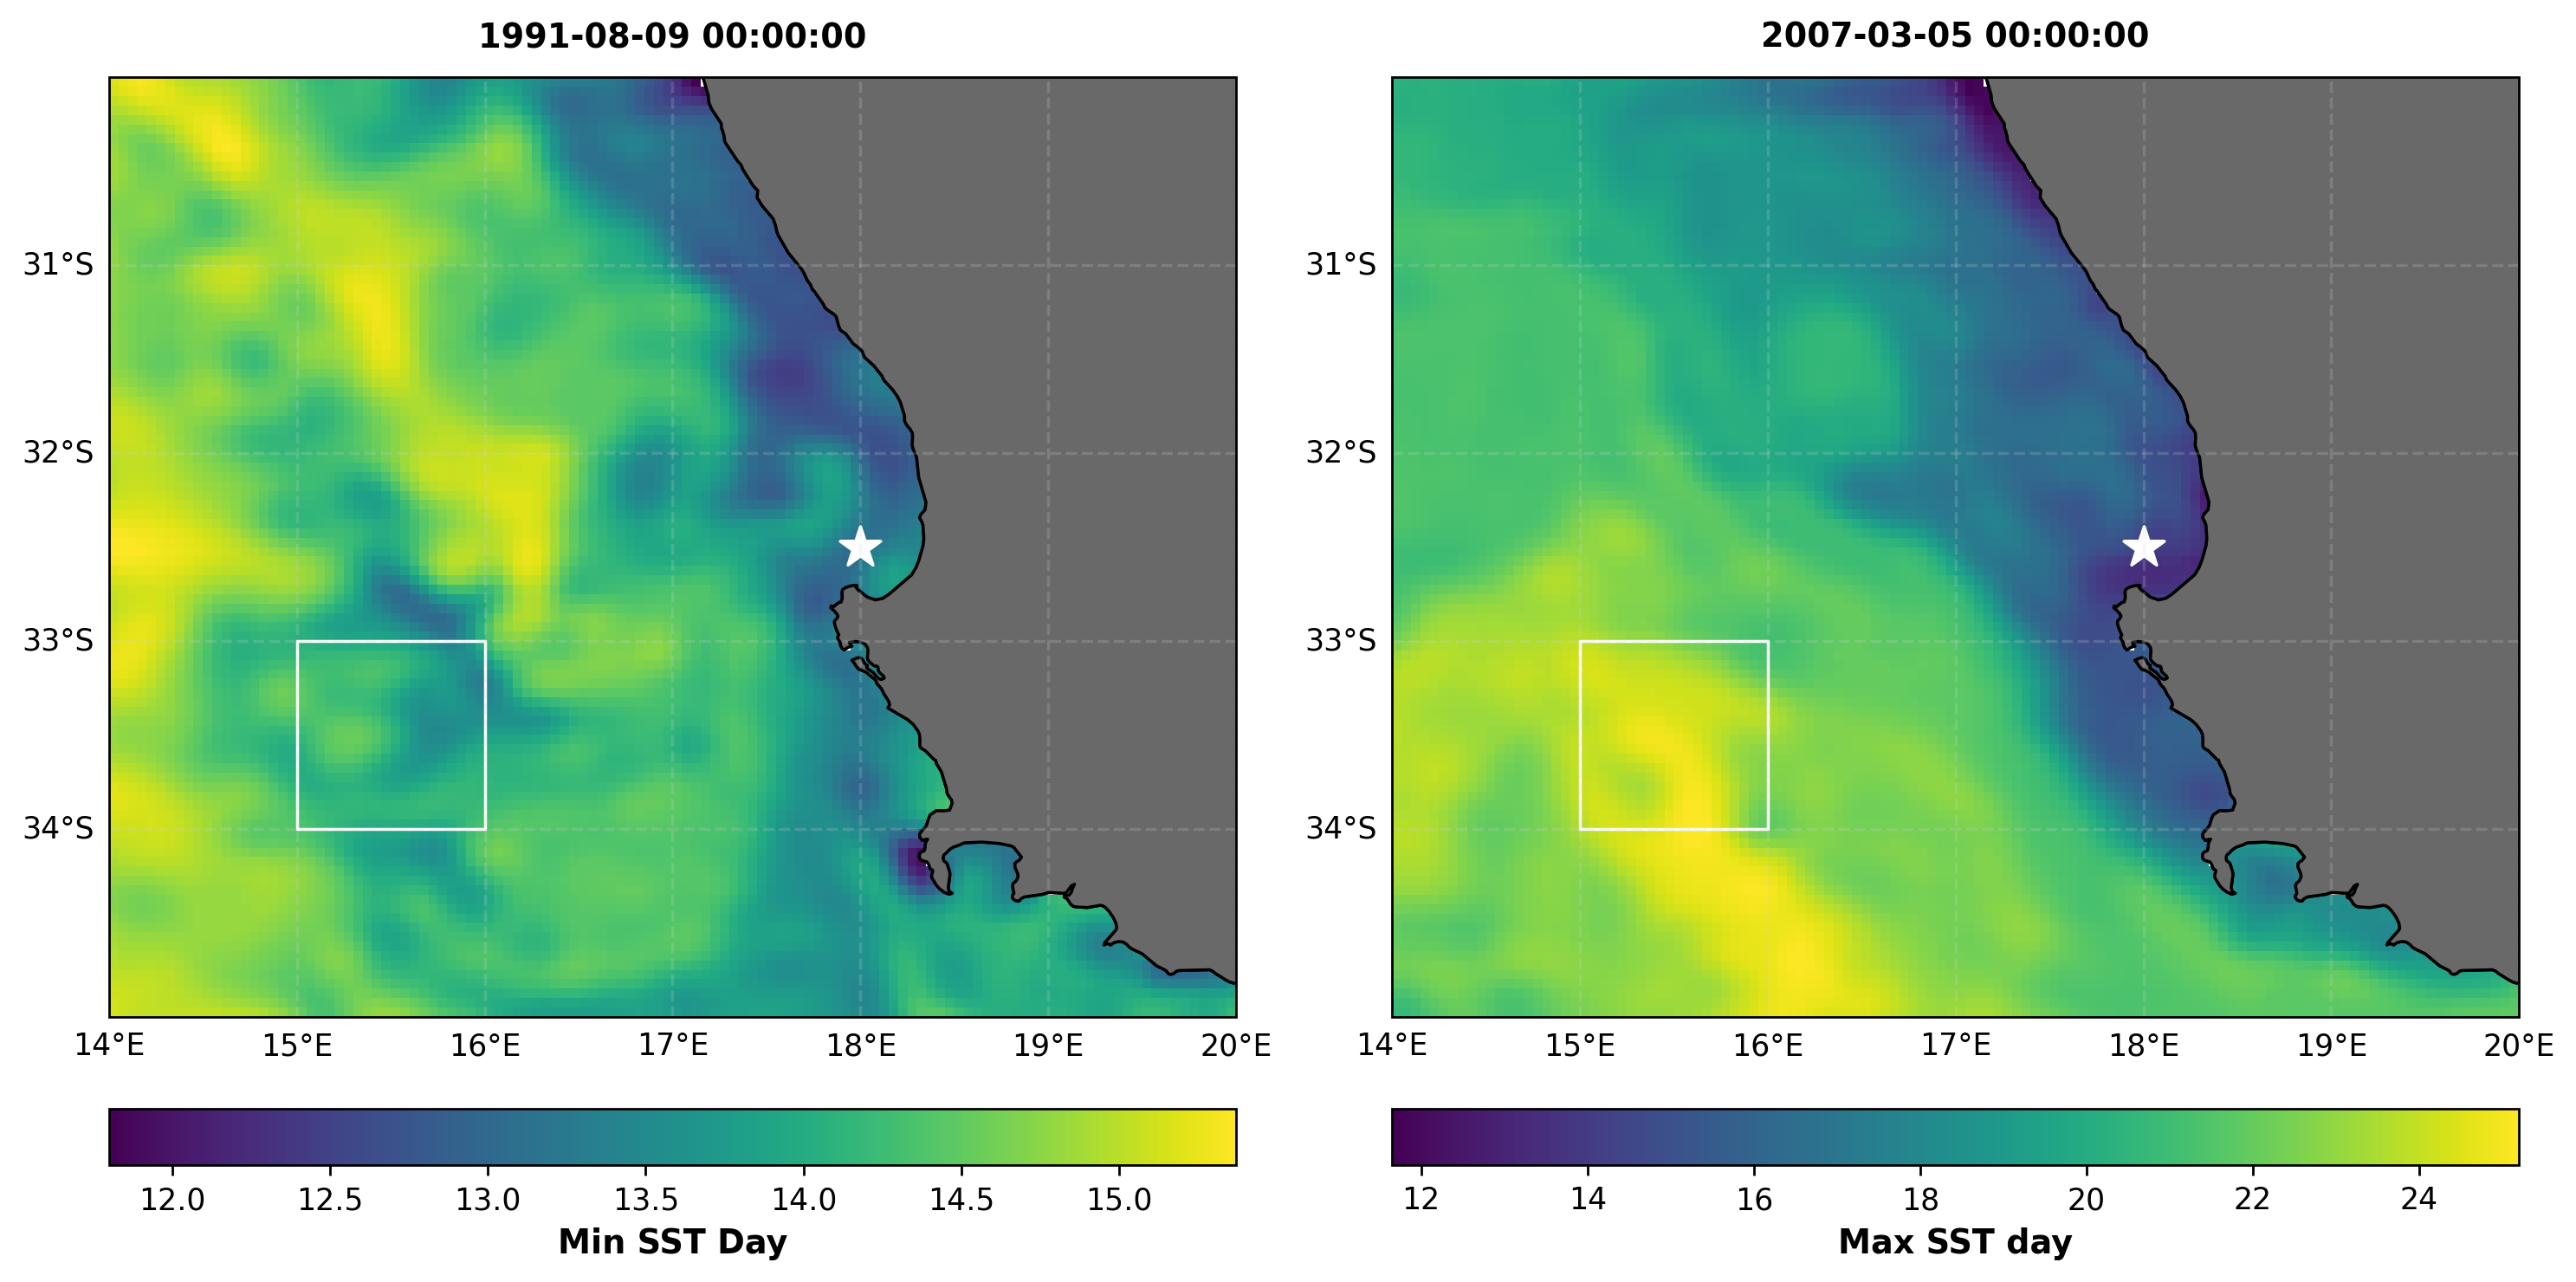

In [22]:
# Shared settings from Fig 1 plus new bounding box
lons = [LON_s[0], LON_s[0], LON_s[1], LON_s[1], LON_s[0]]
lats = [LAT_s[0], LAT_s[1], LAT_s[1], LAT_s[0], LAT_s[0]]
# ---------------------------------------------------------------------------
# Plot min and max SST days
fig4= plt.figure(figsize = (12, 6), dpi = 250)   # Create figure, axis object
gs  = gridspec.GridSpec(1, 2, figure = fig4)

# Subplot 1: minimum var val
ax = fig4.add_subplot(gs[0, 0], projection = proj)
im = ax.pcolormesh(lon, lat, var[min1], cmap = 'viridis')
# optional: set colour limits
#im.set_clim(7, 9.5)
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False
# add selected pixel position and subset
ax.scatter(LON_p, LAT_p, **point_kwargs)
ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor = 'none', alpha = 1,
                  edgecolor = 'white', linewidth = 1, linestyle = '-')
# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Min SST Day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts1.idxmin(), fontsize = 11, weight = 'bold', pad = 10)

# Subplot 2: maximum var val
ax = fig4.add_subplot(gs[0, 1], projection = proj)
im = ax.pcolormesh(lon, lat, var[max1], cmap = 'viridis')
# optional: set colour limits
#im.set_clim(18, 21.5)
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False
# add selected pixel position and subset
ax.scatter(LON_p, LAT_p, **point_kwargs)
ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor = 'none', alpha = 1,
                  edgecolor = 'white', linewidth = 1, linestyle = '-')
# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Max SST day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts1.idxmax(), fontsize = 11, weight = 'bold', pad = 10)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    2. Trend analysis for full AoI (space) over full dataseries (time)
</div>

In [23]:
# Generate a mean of all pixels in AoI
var_m = np.nanmean(var, axis = (1, 2))

In [24]:
# Perform Mann Kendall Test
trend_true = mk.original_test(var_m)

# Print results in a friendly format
print("Daily SST")
print("• Trend:", trend_true[0])
print("• P-val:", ("%.4f" % trend_true[2]))

Daily SST
• Trend: increasing
• P-val: 0.0007


In [25]:
# OLS
slope2, intercept2, r_val2, p_val2, std_err2 = linregress(x, var_m)

# total change over time series (in days)
days  = x[-1] - x[0]
total2= slope2 * days

print(f"Slope : {slope2:.6f} °C /day")
print(f"Change: {total2:.6f} °C over time ({days:.0f} days)")
print(f"p-val = {p_val2:.3g}")

# prepare fit line for plotting (next cell)
x_fit2 = np.linspace(x.min(), x.max(), 100)
y_fit2 = intercept2 + slope2 * x_fit2

Slope : 0.000008 °C /day
Change: 0.122586 °C over time (14609 days)
p-val = 0.00645


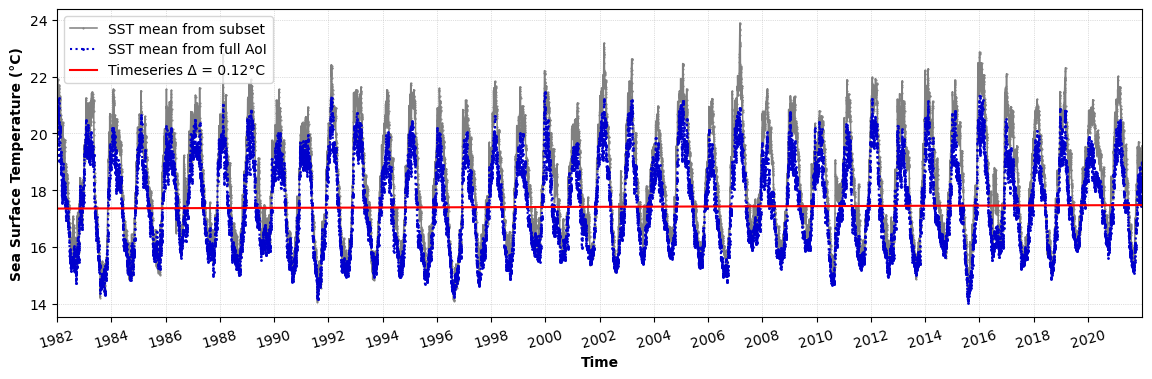

In [26]:
# Plot min and max SST days
fig5, ax = plt.subplots(figsize = (14, 4))   # Create figure, axis object

# plot mean values from subset over time
ax.plot(dtime, var_s, linewidth = 1.1, linestyle = '-', marker = '.', markersize = 1, 
        color = 'grey',  label = 'SST mean from subset')
# plot mean values from AoI over time
ax.plot(dtime, var_m, linewidth = 1.5, linestyle = ':', marker = 'o', markersize = 1, 
        color = 'mediumblue', label = 'SST mean from full AoI')

# plot regression line
ax.plot(num2date(x_fit2), y_fit2, '-r', linewidth = 1.5,
       label = f"Timeseries Δ = {total2:.2f}°C")

# Set axis labels and title
ax.set_xlabel('Time', fontsize = 10, weight = 'bold')
ax.set_ylabel('Sea Surface Temperature (°C)', fontsize = 10, weight = 'bold')

# Add grid formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
# Set x-axis limits with Date min to max
ax.set_xlim([np.nanmin(x), np.nanmax(x)])

# Date Formatting: Define x-axis locator (n yrs)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
# Format x-axis as Year (%Y)/ Year-Month (%Y-%m)
date_form = DateFormatter('%Y')                
# Rotate x-axis labels n degrees
plt.setp(ax.get_xticklabels(), rotation = 15)  

# Display
ax.legend()
plt.show()

In [27]:
# simple series of variable over time (timeseries, ts1)
ts2 = pd.Series(var_m, index = dtime)

# Positions min/max values
max2 = np.nanargmax(var_m)
min2 = np.nanargmin(var_m)

print("Mean:", round(ts2.mean(),   2))
print("Med :", round(ts2.median(), 2))
print("Min :", round(ts2.min(), 2), "on", ts2.idxmin(), "at position", min2)
print("Max :", round(ts2.max(), 1), "on", ts2.idxmax(), "at position", max2)

Mean: 17.41
Med : 17.25
Min : 14.02 on 2015-08-02 00:00:00 at position 12266
Max : 21.5 on 1999-12-24 00:00:00 at position 6566


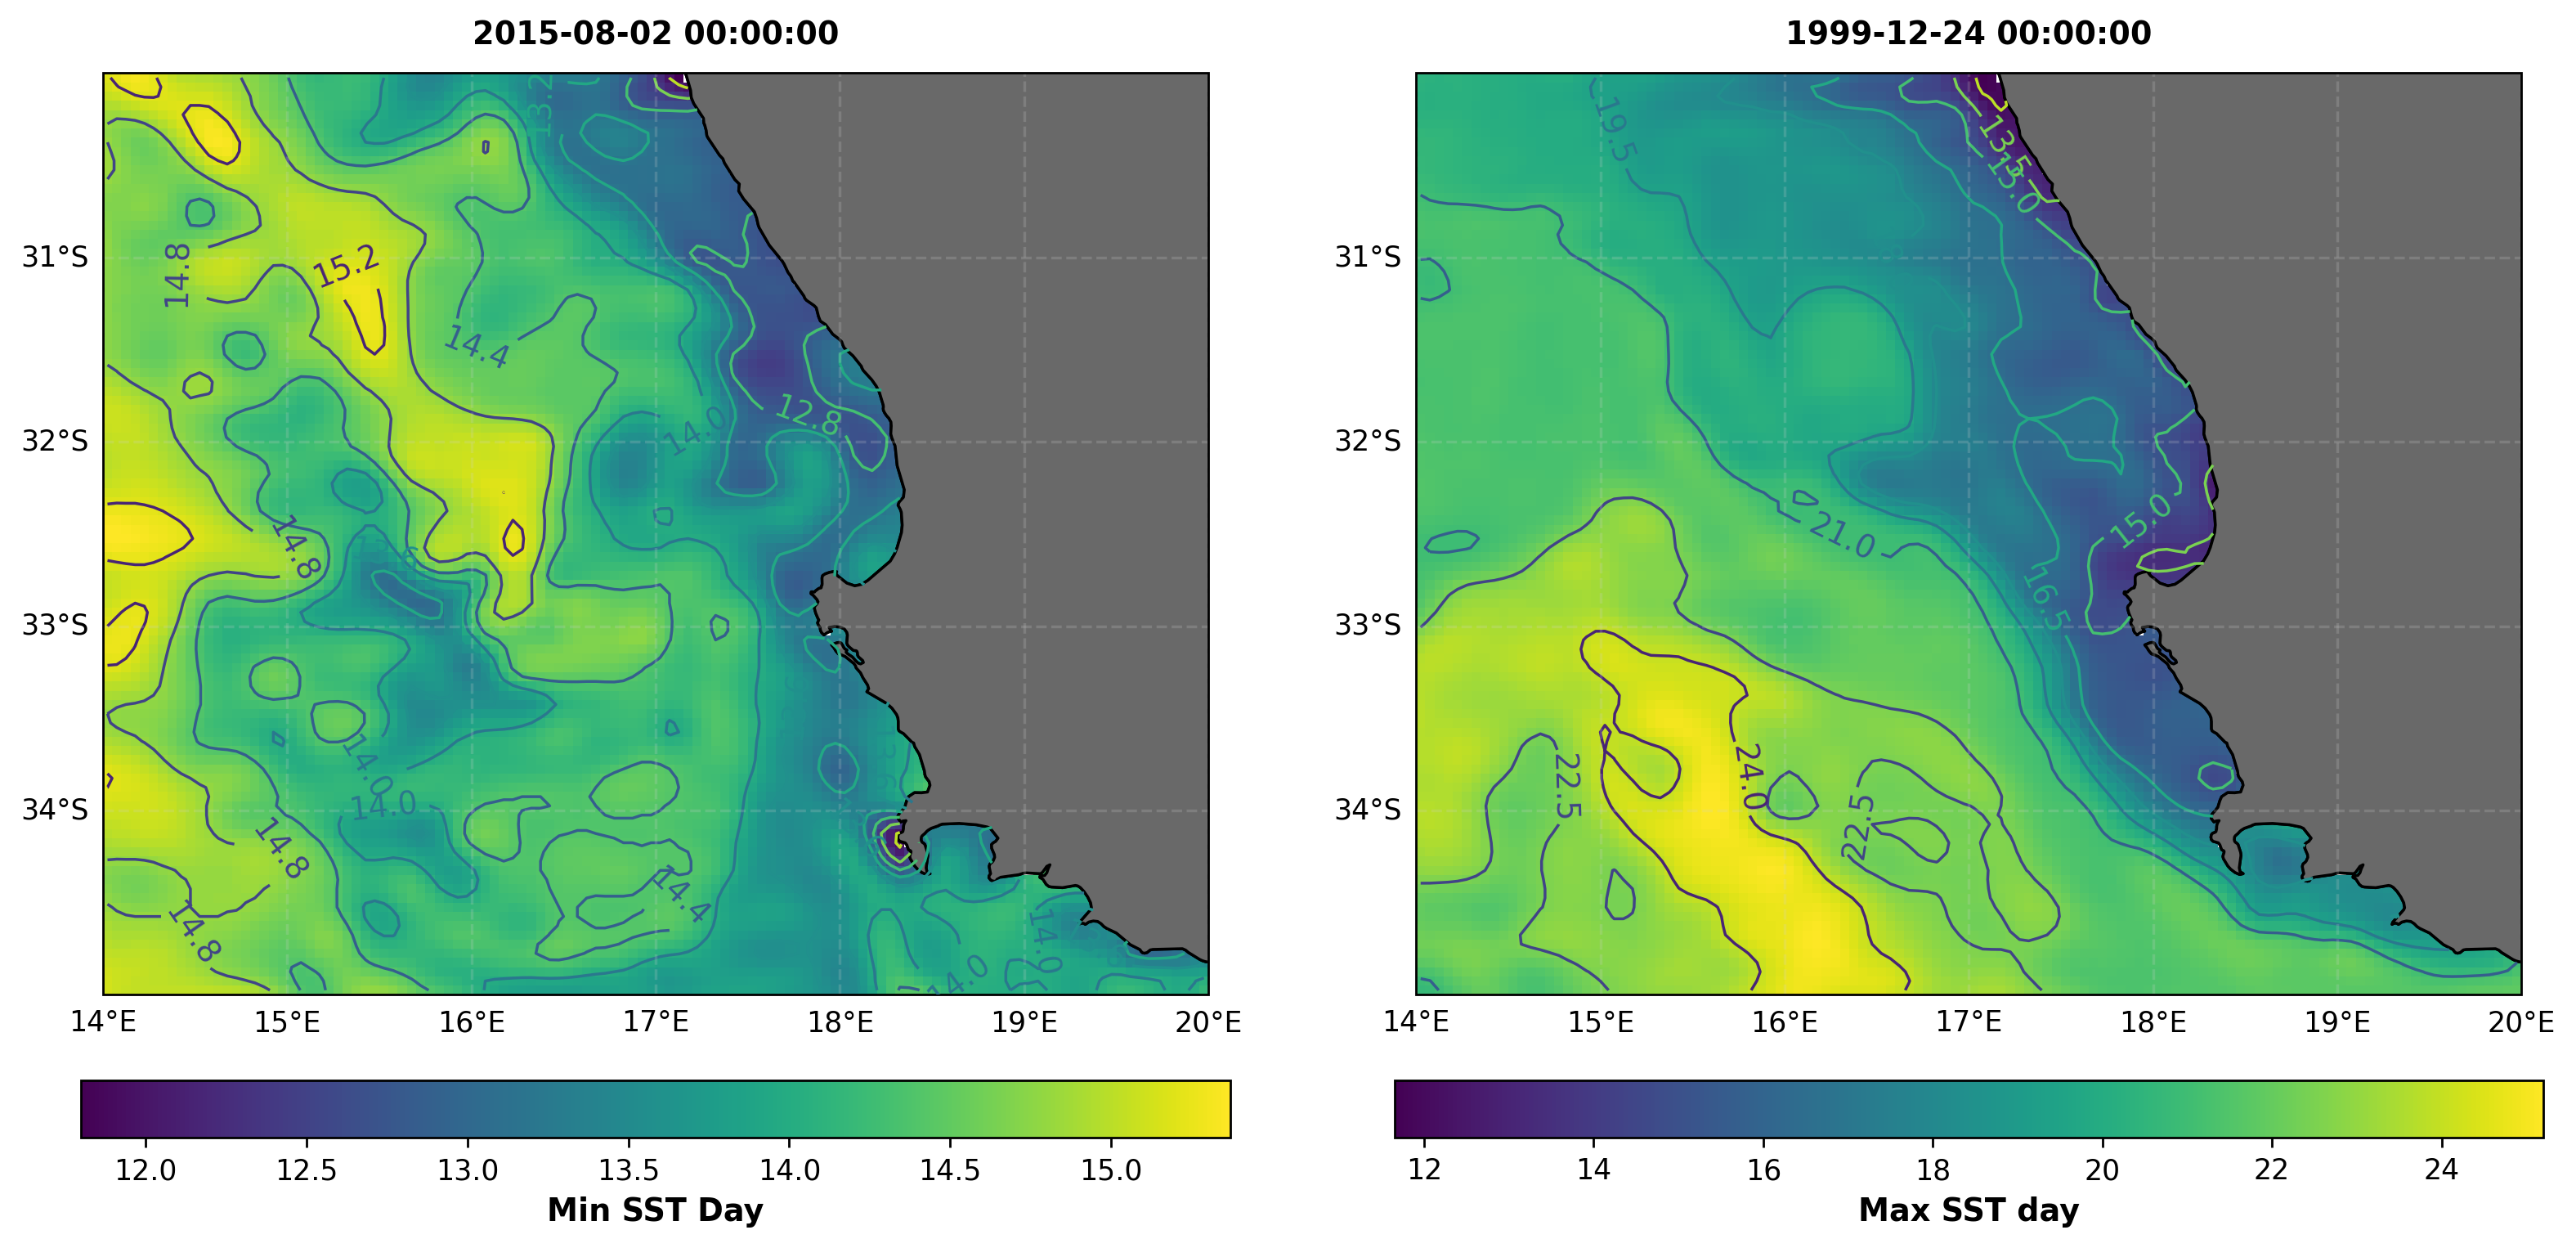

In [28]:
# Create a figure and axis object
fig6= plt.figure(figsize = (13, 6), dpi = 250)
gs  = gridspec.GridSpec(1, 2, figure = fig6)

# Subplot 1: minimum var val
ax = fig6.add_subplot(gs[0, 0], projection = proj)
im = ax.pcolormesh(lon, lat, var[min1], cmap = 'viridis')
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False

# Add contours with appropriate levels and labels
cs = ax.contour(lon, lat, var[min1], levels = 10, 
                transform = proj, cmap = 'viridis_r', linewidths = 1)
ax.clabel(cs, fontsize = 11, inline = True)  # Add labels to contours

# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Min SST Day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts2.idxmin(), fontsize = 11, weight = 'bold', pad = 10)

# Subplot 2: maximum var val
ax = fig6.add_subplot(gs[0, 1], projection = proj)
im = ax.pcolormesh(lon, lat, var[max1], cmap = 'viridis')
# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False

# Add contours with appropriate levels and labels
cs = ax.contour(lon, lat, var[max1], levels = 10, 
                transform = proj, cmap = 'viridis_r', linewidths = 1)
ax.clabel(cs, fontsize = 11, inline = True)  # Add labels to contours

# colourbar
cbar = plt.colorbar(im, ax = ax, **cbars_kwargs)
cbar.set_label('Max SST day', fontsize = 11, weight = 'bold')
# add title
ax.set_title(ts2.idxmax(), fontsize = 11, weight = 'bold', pad = 10)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Comparisons of Pixel, Subset, and Spatial Mean SST values over time
</div>

In [29]:
summary = {"Min SST°C": [ts0.min(), ts1.min(), ts2.min()],
           "Max SST°C": [ts0.max(), ts1.max(), ts2.max()],
           "Mean SST°C": [ts0.mean(), ts1.mean(), ts2.mean()],
           "Time Series Δ °C": [total0, total1, total2]}

headers = ["Specified Pixel", "Spatial Subset", "Full Region AoI"]

# Dataframe: general table formatting
tabledf = pd.DataFrame(summary, index = headers)
# round all values to n decimal places
tabledf = tabledf.map("{:.3f}".format)

# Show Sum Table
print()
print(f"Table 1: minimum, maximum, mean, and change in SST over {years} years\n"
      "for 1 specific pixel, a spatial subset, and the full region AOI.")
display(tabledf)


Table 1: minimum, maximum, mean, and change in SST over 40 years
for 1 specific pixel, a spatial subset, and the full region AOI.


,Min SST°C,Max SST°C,Mean SST°C,Time Series Δ °C
Specified Pixel,11.240,20.720,14.325,-0.633
Spatial Subset,14.049,23.894,18.297,0.434
Full Region AoI,14.019,21.465,17.412,0.123


<div class="alert alert-info" role="alert" 
     style="font-size: 1.em; text-align: left; border-radius: 8px;">
    
    This is such an important result! 

    If we had treated the full AoI as representative of all SST patterns and trends in this region, we would have come away with the wrong idea. Upwelling right up against the coastline shows a significant negative (cooling) trend in SST over time, while the offshore subset is experiencing an overall increase that is also significant. The region is showing an overall rise in SST, despite strong coastal cooling.

    We can also demonstrate these differences visually and statistically...
   
    
<div>

In [30]:
# Mapping per-pixel SST trends through time
n_time, n_lat, n_lon = var.shape
slope = np.full((n_lat, n_lon), np.nan)
x = np.arange(n_time)  # time axis as index

# 1st degree polynomial through z (time) dimension
# i.e. fit a linear trend to each pixel timeseries
for i in range(n_lat):
    for ii in range(n_lon):
        # get the SST ts for each [lat, lon] grid
        y = var[:, i, ii]
        
        # mask missing data (e.g.: land or cloud)
        mask = ~np.isnan(y)
        # skip if fewer than *2 valid data points
        if np.count_nonzero(mask) < 2:
            continue  
        x_masked = x[mask]
        y_masked = y[mask]

        # pixel-wise y = mx + c for slope, m
        m, _ = np.polyfit(x_masked, y_masked, 1)
        slope[i, ii] = m

# Total SST change over time:
change = slope * (n_time - 1)

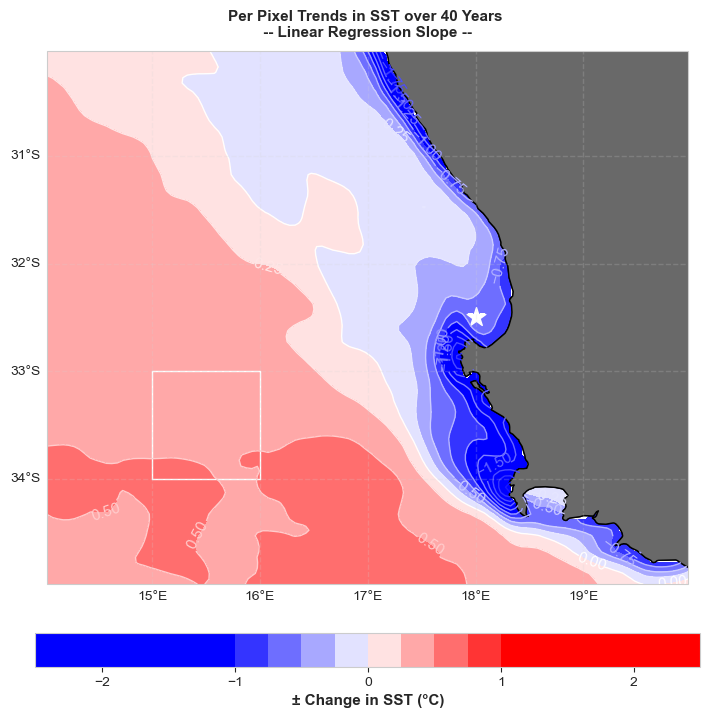

In [35]:
# Create a figure and axis object
fig7, ax = plt.subplots(figsize = (12, 8), 
                        subplot_kw = dict(projection = proj))

# Main contourf plot
levels  = np.linspace(-2.5, 2.5, 21)
contour = ax.contourf(lon, lat, change, levels = levels, cmap = 'bwr',
                      vmin = -1.1, vmax = 1.1, transform = ccrs.PlateCarree())

# format with shared settings
ax.coastlines('10m')
ax.add_feature(land)
g = ax.gridlines(**grids_kwargs)
g.xlabels_top  = False
g.ylabels_right= False

# add selected pixel position and subset
ax.scatter(LON_p, LAT_p, **point_kwargs)
ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor = 'none', alpha = 1,
                  edgecolor = 'white', linewidth = 1, linestyle = '-')

# Add contours with appropriate levels and labels
cs = ax.contour(lon, lat, change, levels = levels, 
                transform = ccrs.PlateCarree(), cmap = 'bwr', linewidths = 1)
ax.clabel(cs, fontsize = 11, inline = True)  # Add labels to contours

# colourbar
cbar = plt.colorbar(contour, ax = ax, ticks = [-2, -1, 0, 1, 2], **cbars_kwargs)
cbar.set_label('± Change in SST (°C)',  fontsize = 11, weight = 'bold')# Add header
ax.set_title(f'Per Pixel Trends in SST over {years} Years \n-- Linear Regression Slope --', 
             fontsize = 11, weight = 'bold', pad = 10)
plt.show()

In [36]:
fig7.savefig('SST_per-pixel-mapped-trends.png', dpi = 300, bbox_inches = 'tight')

In [32]:
# KruskalWallis test (normality not assumed)
kw_stat, kw_p = kruskal(var_p, var_s, var_m)
# print results
print(f"KW p-val = {kw_p:.4f}")
print()

if kw_p <= 0.05:
    # Stack data and create group labels
    data = np.concatenate([var_p, var_s, var_m])
    groups = (['var_p'] * len(var_p)) + (['var_s'] * len(var_s)) + (['var_m'] * len(var_m))

    # Dunn's test (with Bonferroni correction)
    posthoc = sp.posthoc_dunn([var_p, var_s, var_m], p_adjust = 'bonferroni')
    # round all values to n decimal places
    posthoc = posthoc.map("{:.1f}".format)
    print(posthoc)

KW p-val = 0.0000

     1    2    3
1  1.0  0.0  0.0
2  0.0  1.0  0.0
3  0.0  0.0  1.0


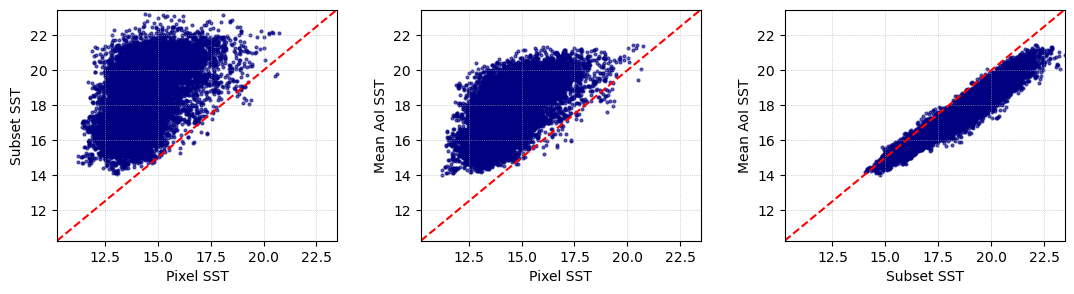

In [33]:
from matplotlib.ticker import FormatStrFormatter

# Create side-by-side scatterplots
fig8, axes = plt.subplots(1, 3, figsize = (13, 3))
fig8.subplots_adjust(wspace = 0.30)     # gap between subplots

# Shared attributes
xlim = ((ts0.min()-1), (ts2.max()+2))
ylim = ((ts0.min()-1), (ts2.max()+2))
line = [xlim, xlim]

# In each subplot:
for ax in axes:
    ax.grid(True, linestyle = ':', linewidth = 0.5)
    ax.plot(line[0], line[1], '--', color = 'red', linewidth = 1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ── pixel vs subset ──────────────────────────────
axes[0].scatter(var_p, var_s, color = 'navy', alpha = 0.6, s = 4)
axes[0].set_xlabel('Pixel SST')
axes[0].set_ylabel('Subset SST')

# ── pixel vs spatial mean ───────────────────────
axes[1].scatter(var_p, var_m, color = 'navy', alpha = 0.6, s = 4)
axes[1].set_xlabel('Pixel SST')
axes[1].set_ylabel('Mean AoI SST')

# ── subset vs spatial mean ───────────────────────
axes[2].scatter(var_s, var_m, color = 'navy', alpha = 0.6, s = 4)
axes[2].set_xlabel('Subset SST')
axes[2].set_ylabel('Mean AoI SST')

plt.show()

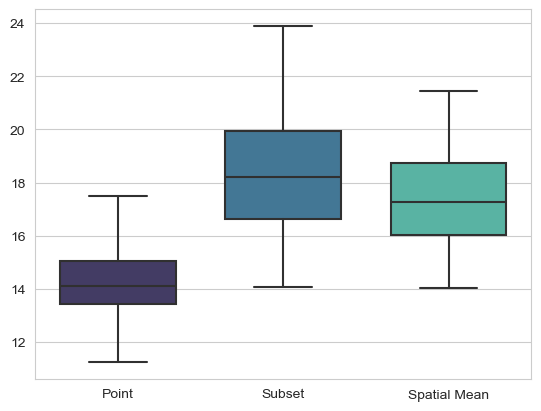

In [34]:
# Boxplot with Seaborn
import seaborn as sns
fit1df = pd.DataFrame({'Point': var_p, 'Subset': var_s, 'Spatial Mean': var_m})
sns.set_style('whitegrid')
ax = sns.boxplot(fit1df, width = 0.7, palette = "mako", showfliers = False)
#ax= sns.stripplot(fit1df, palette="flare", s = 1)